In [1]:
import numpy as np
import pandas as pd
import pickle
import os
import time
import matplotlib.pyplot as plt

helper functions

In [2]:
def r2_score(y_pred, y_test):
    return 1- np.sum((y_pred-y_test)**2)/np.sum(y_test**2)

def train_test_split(all_x, all_y, test_size):
    n = int(len(all_x)*(1-test_size))
    
    x_train, x_test = all_x[:n].copy(), all_x[n:].copy()
    y_train, y_test = all_y[:n].copy(), all_y[n:].copy()
    
    return x_train,x_test,y_train,y_test

In [3]:
def combine_rfs(rf_a, rf_b):
    rf_a.estimators_ += rf_b.estimators_
    rf_a.n_estimators = len(rf_a.estimators_)
    return rf_a

In [4]:
import pickle

def model2pickle(model,filename,filepath=""):
    outfile = open(filepath+filename,'wb')
    pickle.dump(model,outfile)
    outfile.close()

def pickle2model(filename,filepath=""):
    infile = open(filepath+filename,'rb')
    model = pickle.load(infile)
    infile.close()
    return model

In [5]:
def RF87slice(this_regr_params, X_train, y_train, X_test, y_test):
    train_score = []
    valid_score = []
    for i in range(87):   

        regr_temp = RandomForestRegressor(**this_regr_params)

        X_train_this, y_train_this = X_train[i::87], y_train[i::87]
        regr_temp.fit(X_train_this, y_train_this)

        if i == 0:
            regr = regr_temp
        else:
            regr = combine_rfs(regr, regr_temp)

        train_score.append(regr_temp.score(X_train_this, y_train_this.values))
        valid_score.append(regr.score(X_test, y_test.values))

        if i%20 == 0 or i ==86:
            print(str(i)+':\ttemp train score: %.6f, valid score: %.6f'%(train_score[-1],valid_score[-1]))
    return regr, train_score, valid_score

### load raw data

In [8]:
df_raw = pd.read_csv('../data-training.csv')

In [9]:
df = df_raw.copy()

col = np.array(df.columns)

askrate_col = [ x for x in col if 'askRate' in x]
bidrate_col = [ x for x in col if 'bidRate' in x][::-1]
asksize_col = [ x for x in col if 'askSize' in x]
bidsize_col = [ x for x in col if 'bidSize' in x][::-1]

rate_col = bidrate_col+askrate_col
size_col = bidsize_col+asksize_col

df[size_col] = df[size_col].fillna(0)

### calculating features

In [10]:
df[size_col] = df[size_col].fillna(0)

# price
df['midprice'] = (df['askRate0'] + df['bidRate0'])/2
for i in range(3):
    df['bookprice'+str(i)] = (df['askRate'+str(i)]*df['bidSize'+str(i)] + df['bidRate'+str(i)]*df['askSize'+str(i)])/(df['askSize'+str(i)] + df['bidSize'+str(i)])

# spread
df['spread'] = df['askRate0'] - df['bidRate0']

In [11]:
# volume
df['askSize_ttl'] = df[asksize_col].sum(axis=1)
df['bidSize_ttl'] = df[bidsize_col].sum(axis=1)

# volume imbalance = bidsize/(bidsize+asksize) in (0,1), more buy when higher
for i in range(15):
    df['volumn_imb_'+str(i)] = 1/(1+df['askSize'+str(i) ]/df['bidSize'+str(i)])

df['volumn_imb_3+'] = 1/(1+df[['askSize'+str(i) for i in range(3,15)]].sum(axis=1)/df[['bidSize'+str(i) for i in range(3,15)]].sum(axis=1))

In [12]:
# volume change
for lag in [5,15,45,87,180]:
    for level in range(3):
        for x in ['askSize','bidSize']:
            df[x+str(level)+'_chg'+str(lag)] = df[x+str(level)].diff(lag)/lag

In [13]:
# rate change
for lag in [5,15,45,87,180]:
    for level in range(3):
        for x in ['askRate','bidRate']:
            df[x+str(level)+'_chg'] = df[x+str(level)].diff(lag)/lag

In [14]:
# rate sparsity
for level in [1,2,3,7,14]:
    for x in ['askRate','bidRate']:
        df[x+str(level)+'_dev'] = df[x+str(level)] - df[x+str(0)]

In [15]:
# moving average of prices / spread
for lag in [5,15,45,87,180,360]:
    for col in ['midprice','spread','bookprice0']:
        df[col+'_ma'+str(lag)]=df[col].rolling(lag).mean()
  

In [16]:
# std of prices / spread
for lag in [5,15,45,87,180,360]:
    for col in ['midprice','spread','bookprice0']:
        df[col+'_std'+str(lag)]=df[col].rolling(lag).std()

In [17]:
# price change
for lag in [5,15,45,87,180,360]:
    for col in ['midprice','spread','bookprice0']:
        df[col+'_chg'+str(lag)]=df[col].diff(lag)

In [18]:
# volume imbalance change
for lag in [5,15,45,87,180,360]:
    for i in [0,1,2,'3+']:
        df['volumn_imb_'+str(i)+'_chg'+str(lag)] = df['volumn_imb_'+str(i)].diff(lag)

In [19]:
def AddRateDiffFeature(t,level_max=2):
    for i in range(level_max+1):
        t['bidRatediff'+str(i)+str(i+1)]=np.clip( (t['bidRate'+str(i)]-t['bidRate'+str(i+1)]).abs()-0.5, a_min=0, a_max=2.5 )
        t['askRatediff'+str(i)+str(i+1)]=np.clip( (t['askRate'+str(i)]-t['askRate'+str(i+1)]).abs()-0.5, a_min=0, a_max=2.5 )
    t['bidRatediff']=t[['bidRatediff'+str(i)+str(i+1) for i in range(level_max+1)]].fillna(0).sum(axis=1)
    t['askRatediff']=t[['askRatediff'+str(i)+str(i+1) for i in range(level_max+1)]].fillna(0).sum(axis=1)
    t['bard']=t['bidRatediff']-t['askRatediff']
    return t

df=AddRateDiffFeature(df,2)

In [20]:
ft_original = ['spread','bard']

# midprice change
for lag in [5,15,45,87,360]:
    ft_original.append('midprice_chg'+str(lag))

# moving average of prices / spread
for lag in [5,15,45,87,360]:
    for col in ['spread']:
        ft_original.append(col+'_ma'+str(lag))

# std of prices
for lag in [5,15,45,87,360]:
    for col in ['midprice']:
        ft_original.append(col+'_std'+str(lag))

# volume imbalance
for i in [0,1,2,'3+']:
    ft_original.append('volumn_imb_'+str(i))

# volume imbalance change
for lag in [5,15,45,87,360]:
    for i in [0,1,2,'3+']:
        ft_original.append('volumn_imb_'+str(i)+'_chg'+str(lag))

# volume change
for lag in [5,15,45,87,180]:
    for level in range(3):
        for x in ['askSize','bidSize']:
            ft_original.append(x+str(level)+'_chg'+str(lag))
            
# rate sparsity
for level in [1,2,3,7,14]:
    for x in ['askRate','bidRate']:
        ft_original.append(x+str(level)+'_dev')

## load order book

In [21]:
df_orders = pd.read_csv('../data-orderbook.csv', index_col=0)

/Users/shiyu/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [22]:
for x in ['ask','bid']:
    df_orders['lmt_'+x+'_new3+'] = df_orders['lmt_'+x+'_new3']+df_orders['lmt_'+x+'_new4']\
                          +df_orders['lmt_'+x+'_new5']+df_orders['lmt_'+x+'_new6-10']\
                          +df_orders['lmt_'+x+'_new11+']

#### merge the data into df

In [24]:
col_orders_tomerge = ['mkt_ask','mkt_bid',
                      'lmt_bid_nrw','lmt_ask_nrw',
                      'lmt_bid_cnl_ttl','lmt_ask_cnl_ttl',
                      'lmt_bid_cnl_b3','lmt_ask_cnl_b3',
                      'lmt_bid_new0','lmt_bid_new1','lmt_bid_new2','lmt_bid_new3+',
                      'lmt_ask_new0','lmt_ask_new1','lmt_ask_new2','lmt_ask_new3+']

for c in col_orders_tomerge:
    df[c] = df_orders[c].fillna(0)

In [25]:
col_orders_st = ['mkt_ask','mkt_bid',
                 'lmt_bid_nrw','lmt_ask_nrw',
                 'lmt_bid_cnl_ttl','lmt_ask_cnl_ttl',
                 'lmt_bid_cnl_b3','lmt_ask_cnl_b3',
                 'lmt_bid_new0','lmt_bid_new1','lmt_bid_new2',
                 'lmt_ask_new0','lmt_ask_new1','lmt_ask_new2']
col_orders_lt = ['lmt_bid_new3+', 'lmt_ask_new3+']

ft_orders = []

for c in col_orders_st:
    df[c+'_acc10'] = df[c].rolling(10).sum()
    ft_orders.append(c+'_acc10')
    
for c in col_orders_lt:
    df[c+'_acc360'] = df[c].rolling(360).sum()
    ft_orders.append(c+'_acc360')

### new feature - time stays on current midprice/askRate0/bidRate0

In [26]:
mp_tim = np.ones(len(df))

for i in range(1,len(df)):
    if df['midprice'][i] == df['midprice'][i-1]:
        mp_tim[i]=mp_tim[i-1]+1

In [27]:
df['midprice_stay']=mp_tim

### new feature - weighted ask/bid/spread/midprice

In [28]:
df['askRate_weighted'] = np.nansum(df[askrate_col].values*df[asksize_col].values,axis=1)
df['bidRate_weighted'] = np.nansum(df[bidrate_col].values*df[bidsize_col].values,axis=1)
df['midprice_weighted'] = (df['askRate_weighted']+df['bidRate_weighted'])/2
df['spread_weighted'] = df['askRate_weighted']-df['bidRate_weighted']

### new feature -  intensity

In [29]:
df['mkt_ask_int']= df_orders['mkt_ask']/df['midprice_stay']
df['mkt_bid_int']= df_orders['mkt_bid']/df['midprice_stay']

In [30]:
ft_weighted = ['askRate_weighted','bidRate_weighted','midprice_weighted','spread_weighted']
ft_intensity = ['mkt_ask_int','mkt_bid_int']

### full features

In [31]:
ft_full = list(ft_original) + list(ft_orders) + list(ft_weighted) + list(ft_intensity)

In [32]:
len(ft_full)

103

## df_demean: normalize the features by mean and range

In [33]:
# for whole book
df_demean = df.copy()
df_demean[ft_full] = (df_demean[ft_full]-df_demean[ft_full].mean())/(df_demean[ft_full].max()-df_demean[ft_full].min())
y_all = df_demean['y'].copy()

n = int(0.8*len(df_demean))
t_train = df_demean[:n].copy().fillna(0)
t_test = df_demean[n:].copy().fillna(0)

In [36]:
# depend on the features
ft = ft_full
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

### not normalized

In [37]:
# depend on the features
ft = ft_full
X_all_x = df[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all_x, y_all, 0.2)

# FEATURES TEST

In [34]:
from sklearn.ensemble import RandomForestRegressor

regr_parameters = {
    'min_samples_leaf': 100,
    'n_estimators': 2,
    'n_jobs': -1,
    'random_state': 0}

### last submission: ft_originals

In [40]:
# no norm
ft = ft_original
ft.remove('bard')
X_all = df[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_org_x, train_score, valid_score = RF87slice(regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.059790, valid score: -0.035252
10:	temp train score: 0.060399, valid score: 0.018712
20:	temp train score: 0.056699, valid score: 0.021306
30:	temp train score: 0.057101, valid score: 0.022913
40:	temp train score: 0.059127, valid score: 0.023705
50:	temp train score: 0.061136, valid score: 0.024161
60:	temp train score: 0.056430, valid score: 0.024315
70:	temp train score: 0.062140, valid score: 0.024492
80:	temp train score: 0.062404, valid score: 0.024312
86:	temp train score: 0.060463, valid score: 0.024356


#### add bard

In [39]:
# no norm 
ft = ft_original
X_all = df[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_org_x, train_score, valid_score = RF87slice(regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.059790, valid score: -0.035252
10:	temp train score: 0.059648, valid score: 0.018936
20:	temp train score: 0.056699, valid score: 0.021472
30:	temp train score: 0.057101, valid score: 0.022999
40:	temp train score: 0.059127, valid score: 0.023741
50:	temp train score: 0.061136, valid score: 0.024194
60:	temp train score: 0.056430, valid score: 0.024342
70:	temp train score: 0.061478, valid score: 0.024525
80:	temp train score: 0.062404, valid score: 0.024338
86:	temp train score: 0.061187, valid score: 0.024412


In [43]:
# norm
ft = ft_original
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_org, train_score, valid_score = RF87slice(regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.060527, valid score: -0.033111
20:	temp train score: 0.056748, valid score: 0.021297
40:	temp train score: 0.059279, valid score: 0.023715
60:	temp train score: 0.055909, valid score: 0.024293
80:	temp train score: 0.062541, valid score: 0.024296
86:	temp train score: 0.059658, valid score: 0.024337


## BASELINE: ft_full

In [35]:
# no norm
ft = ft_full
X_all = df[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_full_x, train_score, valid_score = RF87slice(regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.061554, valid score: -0.034545
20:	temp train score: 0.059634, valid score: 0.021562
40:	temp train score: 0.062208, valid score: 0.023873
60:	temp train score: 0.062382, valid score: 0.024695
80:	temp train score: 0.061753, valid score: 0.024868
86:	temp train score: 0.059581, valid score: 0.024931


In [36]:
# norm
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_full, train_score, valid_score = RF87slice(regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.061137, valid score: -0.034402
20:	temp train score: 0.059634, valid score: 0.021535
40:	temp train score: 0.062107, valid score: 0.023945
60:	temp train score: 0.062344, valid score: 0.024750
80:	temp train score: 0.062967, valid score: 0.024891
86:	temp train score: 0.059663, valid score: 0.024954


### last time hand picked features

In [37]:
ft_pick = ['bard',
 'midprice_chg45',
 'spread_ma5',
 'volumn_imb_0',
 'volumn_imb_1',
 'volumn_imb_2',
 'volumn_imb_1_chg5',
 'volumn_imb_1_chg360',
 'volumn_imb_2_chg360',
 'volumn_imb_3+_chg360',
 'askSize0_chg15',
 'bidSize0_chg15',
 'askSize0_chg180',
 'bidSize0_chg180',
 'askSize1_chg180',
 'bidSize1_chg180',
 'askRate3_dev',
 'bidRate3_dev',
 'mkt_ask_acc10',
 'mkt_bid_acc10',
 'lmt_bid_cnl_b3_acc10',
 'lmt_ask_cnl_b3_acc10',
 'lmt_bid_new0_acc10',
 'lmt_bid_new1_acc10',
 'lmt_ask_new0_acc10',
 'lmt_ask_new1_acc10',
 'mkt_ask_int',
 'mkt_bid_int',
 'lmt_bid_new2_acc10',
 'lmt_ask_new2_acc10',
 'lmt_bid_new3+_acc360',
 'lmt_ask_new3+_acc360']

In [38]:
# no norm
ft = ft_pick
X_all = df[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_pick_x, train_score, valid_score = RF87slice(regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.048654, valid score: -0.019629
20:	temp train score: 0.048117, valid score: 0.023166
40:	temp train score: 0.049493, valid score: 0.025384
60:	temp train score: 0.051554, valid score: 0.025906
80:	temp train score: 0.051194, valid score: 0.025981
86:	temp train score: 0.050662, valid score: 0.025912


In [39]:
# norm
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_pick, train_score, valid_score = RF87slice(regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.048597, valid score: -0.019684
20:	temp train score: 0.048117, valid score: 0.023166
40:	temp train score: 0.049493, valid score: 0.025390
60:	temp train score: 0.051554, valid score: 0.025906
80:	temp train score: 0.051194, valid score: 0.025984
86:	temp train score: 0.051051, valid score: 0.025919


### ? what if we add two more estimator?

In [40]:
# norm
ft = ft_pick
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

this_regr_parameters = regr_parameters.copy()
this_regr_parameters['n_estimators']=4

regr_pick_nolmt, train_score, valid_score = RF87slice(this_regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.062427, valid score: 0.004142
20:	temp train score: 0.062223, valid score: 0.025048
40:	temp train score: 0.064950, valid score: 0.025957
60:	temp train score: 0.063956, valid score: 0.026393
80:	temp train score: 0.065617, valid score: 0.026647
86:	temp train score: 0.065959, valid score: 0.026625


### ? what if we decrease leaf size?

In [41]:
# norm
ft = ft_pick
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

this_regr_parameters = regr_parameters.copy()
this_regr_parameters['n_estimators']=4
this_regr_parameters['min_samples_leaf']=75

regr_pick_nolmt, train_score, valid_score = RF87slice(this_regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.077283, valid score: -0.002897
20:	temp train score: 0.075324, valid score: 0.025197
40:	temp train score: 0.079247, valid score: 0.026515
60:	temp train score: 0.077153, valid score: 0.026902
80:	temp train score: 0.081189, valid score: 0.027152
86:	temp train score: 0.080132, valid score: 0.027131


### last time hand picked features - no limit order info

In [81]:
ft_pick_nolmt = []
for f in ft_pick:
    if 'lmt' not in f:
        ft_pick_nolmt.append(f)

In [82]:
# no norm
ft = ft_pick_nolmt
X_all = df[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_pick_nolmt_x, train_score, valid_score = RF87slice(regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.044633, valid score: -0.014289
20:	temp train score: 0.043551, valid score: 0.023427
40:	temp train score: 0.046828, valid score: 0.025294
60:	temp train score: 0.047387, valid score: 0.025697
80:	temp train score: 0.050347, valid score: 0.025755
86:	temp train score: 0.047198, valid score: 0.025769


In [83]:
# norm
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_pick_nolmt, train_score, valid_score = RF87slice(regr_parameters, X_train, y_train, X_test, y_test)

0:	temp train score: 0.044635, valid score: -0.014292
20:	temp train score: 0.043551, valid score: 0.023413
40:	temp train score: 0.046828, valid score: 0.025299
60:	temp train score: 0.047387, valid score: 0.025713
80:	temp train score: 0.050347, valid score: 0.025767
86:	temp train score: 0.047198, valid score: 0.025780


# test each group performance on single RF

In [42]:
def RFsingle(this_regr_params, X_train, y_train, X_test, y_test, full=1):
    if full == 1:
        r = range(87)
    else:
        r = range(0,87,full)
        
    for i in r:
        regr_temp = RandomForestRegressor(**this_regr_params)

        X_train_this, y_train_this = X_train[i::87], y_train[i::87]
        regr_temp.fit(X_train_this, y_train_this)

        if i == 0:
            regr = regr_temp
        else:
            regr = combine_rfs(regr, regr_temp)

    return regr, regr.score(X_train, y_train.values), regr.score(X_test, y_test.values)

def test_ft_group(ft_test,ft_full,benchmark,t_train,t_test,regr_parameters,full=5):
    regr_ft = {}
    ft_weak = []
    
    for f in ft_test:

        ft = ft_full.copy()
        ft.remove(f)

        X_train, X_test = t_train[ft], t_test[ft]
        y_train, y_test = t_train['y'], t_test['y']
        
        regr,train_score,valid_score = RFsingle(regr_parameters, X_train, y_train, X_test, y_test,full)
        
        if benchmark == None:
            suffix =''
        elif valid_score > benchmark:
            suffix ='--> beat!'
            ft_weak.append(f)
        else:
            suffix =''
        
        print('%25s: train score: %.6f, valid score: %.6f'%(f,train_score,valid_score)+suffix)
        
        regr_ft[f]=regr
    
    return regr_ft, ft_weak

### group combinations

In [43]:
# [ base case you want to work with]
ft = ft_full
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr, train_score, valid_score_full = RFsingle(regr_parameters, X_train, y_train, X_test, y_test,5)

In [44]:
valid_score_full

0.02271956603738079

In [45]:
# [ base case you want to work with]
ft = ft_pick
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_pick, train_score, valid_score_pick = RFsingle(regr_parameters, X_train, y_train, X_test, y_test,5)

In [46]:
valid_score_pick

0.02437159862544025

# choose the features - benchmark 0.02271956603738079

## ft_original, benchmark, all 104 features

In [47]:
benchmark = valid_score_full
regr_ft_org, ft_weak_org = test_ft_group(ft_original,ft_full,benchmark,t_train,t_test,regr_parameters)

                   spread: train score: 0.028463, valid score: 0.022687
                     bard: train score: 0.028351, valid score: 0.022478
            midprice_chg5: train score: 0.028475, valid score: 0.022668
           midprice_chg15: train score: 0.028436, valid score: 0.022707
           midprice_chg45: train score: 0.028474, valid score: 0.022693
           midprice_chg87: train score: 0.028343, valid score: 0.022754--> beat!
          midprice_chg360: train score: 0.028456, valid score: 0.022728--> beat!
               spread_ma5: train score: 0.028472, valid score: 0.022737--> beat!
              spread_ma15: train score: 0.028415, valid score: 0.022906--> beat!
              spread_ma45: train score: 0.028387, valid score: 0.022535
              spread_ma87: train score: 0.028316, valid score: 0.022829--> beat!
             spread_ma360: train score: 0.028436, valid score: 0.022226
            midprice_std5: train score: 0.028507, valid score: 0.022677
           midprice

In [101]:
regr_imp = pd.DataFrame(regr.feature_importances_, index = ft_full ).sort_values(0,ascending=False)

In [68]:
regr_imp.head(20)

volumn_imb_0           0.100350
volumn_imb_1           0.034606
midprice_std360        0.032747
volumn_imb_0_chg5      0.030299
midprice_std87         0.026348
bidRate_weighted       0.024619
volumn_imb_0_chg15     0.022485
midprice_weighted      0.020919
askRate_weighted       0.020389
volumn_imb_2           0.019206
volumn_imb_1_chg45     0.019109
midprice_std45         0.018946
volumn_imb_1_chg87     0.018751
volumn_imb_2_chg87     0.018358
spread_ma360           0.018344
volumn_imb_0_chg45     0.017826
volumn_imb_1_chg360    0.017129
volumn_imb_0_chg360    0.016694
volumn_imb_2_chg360    0.015991
volumn_imb_3+_chg45    0.015720
dtype: float64

In [64]:
for f in ft_weak_org:
    if f in regr_imp.iloc[:20]:
        print(f)

midprice_std45
volumn_imb_2
volumn_imb_0_chg5
volumn_imb_0_chg15
volumn_imb_0_chg45
volumn_imb_3+_chg45
volumn_imb_1_chg87
volumn_imb_1_chg360


#### remove all the weak features, to see if r2 improves

In [49]:
ft_full_opt_org = ft_full.copy()
for f in ft_weak_org:
    ft_full_opt_org.remove(f)

ft = ft_full_opt_org
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_opt_org,_,valid_score_opt_org = RFsingle(regr_parameters, X_train, y_train, 
                                                                  X_test, y_test,5)

In [50]:
valid_score_opt_org

0.023583779310526465

In [88]:
regr_imp_opt_org = pd.Series(regr_opt_org.feature_importances_, index = ft_full_opt_org).sort_values(ascending=False)
regr_imp_opt_org['rank'] = regr_imp_opt_org.index

In [74]:
for f in ft_weak_org2:
    if f in regr_imp_opt_org.head(20):
        print(f)

spread_ma45
volumn_imb_1_chg45
volumn_imb_2_chg360
volumn_imb_3+_chg360


#### another round

In [51]:
ft_org_opt_org = ft_original.copy()
for f in ft_weak_org:
    ft_org_opt_org.remove(f)

benchmark = valid_score_opt_org
regr_ft_org2, ft_weak_org2 = test_ft_group(ft_org_opt_org,ft_full_opt_org,benchmark,t_train,t_test,regr_parameters)

                   spread: train score: 0.028183, valid score: 0.023689--> beat!
                     bard: train score: 0.028287, valid score: 0.023526
            midprice_chg5: train score: 0.028325, valid score: 0.023567
           midprice_chg15: train score: 0.028320, valid score: 0.023549
           midprice_chg45: train score: 0.028242, valid score: 0.023460
              spread_ma45: train score: 0.028079, valid score: 0.023728--> beat!
             spread_ma360: train score: 0.028155, valid score: 0.023228
            midprice_std5: train score: 0.028324, valid score: 0.023633--> beat!
           midprice_std15: train score: 0.028318, valid score: 0.023235
           midprice_std87: train score: 0.028222, valid score: 0.023301
          midprice_std360: train score: 0.027932, valid score: 0.023218
             volumn_imb_0: train score: 0.026282, valid score: 0.020379
             volumn_imb_1: train score: 0.027260, valid score: 0.023243
        volumn_imb_1_chg5: train scor

In [69]:
len(ft_weak_org2)

16

In [76]:
ft_full_opt_org2 = ft_full_opt_org.copy()
for f in ft_weak_org2:
    ft_full_opt_org2.remove(f)

ft = ft_full_opt_org2
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_opt_org2,_,valid_score_opt_org2 = RFsingle(regr_parameters, X_train, y_train, 
                                                                  X_test, y_test,5)

In [77]:
valid_score_opt_org2

0.024709003230929283

In [89]:
regr_imp_opt_org2 = pd.Series(regr_opt_org2.feature_importances_, index = ft_full_opt_org2).sort_values(ascending=False)
regr_imp_opt_org2['rank'] = regr_imp_opt_org2.index

#### third round

In [80]:
ft_org_opt_org2 = ft_org_opt_org.copy()
for f in ft_weak_org2:
    ft_org_opt_org2.remove(f)

benchmark = valid_score_opt_org2
regr_ft_org3, ft_weak_org3 = test_ft_group(ft_org_opt_org2,ft_full_opt_org2,benchmark,t_train,t_test,regr_parameters)

                     bard: train score: 0.027313, valid score: 0.024300
            midprice_chg5: train score: 0.027464, valid score: 0.024662
           midprice_chg15: train score: 0.027481, valid score: 0.024717--> beat!
           midprice_chg45: train score: 0.027465, valid score: 0.024830--> beat!
             spread_ma360: train score: 0.027311, valid score: 0.023890
           midprice_std15: train score: 0.027453, valid score: 0.024445
           midprice_std87: train score: 0.027565, valid score: 0.024910--> beat!
          midprice_std360: train score: 0.027471, valid score: 0.024423
             volumn_imb_0: train score: 0.025953, valid score: 0.019796
             volumn_imb_1: train score: 0.026418, valid score: 0.022933
        volumn_imb_1_chg5: train score: 0.027616, valid score: 0.024622
       volumn_imb_3+_chg5: train score: 0.027629, valid score: 0.024800--> beat!
       volumn_imb_1_chg15: train score: 0.027426, valid score: 0.023947
       volumn_imb_2_chg15: t

In [81]:
len(ft_weak_org3)

6

In [82]:
ft_full_opt_org3 = ft_full_opt_org2.copy()
for f in ft_weak_org3:
    ft_full_opt_org3.remove(f)

ft = ft_full_opt_org3
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_opt_org3,_,valid_score_opt_org3 = RFsingle(regr_parameters, X_train, y_train, 
                                                                  X_test, y_test,5)

In [83]:
valid_score_opt_org3

0.024974010267265978

In [90]:
regr_imp_opt_org3 = pd.Series(regr_opt_org3.feature_importances_, index = ft_full_opt_org3).sort_values(ascending=False)

In [102]:
ft_weak_org

['midprice_chg87',
 'midprice_chg360',
 'spread_ma5',
 'spread_ma15',
 'spread_ma87',
 'midprice_std45',
 'volumn_imb_2',
 'volumn_imb_3+',
 'volumn_imb_0_chg5',
 'volumn_imb_0_chg15',
 'volumn_imb_3+_chg15',
 'volumn_imb_0_chg45',
 'volumn_imb_2_chg45',
 'volumn_imb_3+_chg45',
 'volumn_imb_1_chg87',
 'volumn_imb_1_chg360',
 'askSize1_chg5',
 'askSize2_chg5',
 'bidSize2_chg15',
 'askSize0_chg45',
 'bidSize2_chg45',
 'bidSize0_chg87',
 'askSize1_chg87',
 'bidSize1_chg87',
 'bidSize2_chg87',
 'askSize1_chg180',
 'bidSize1_chg180',
 'bidSize2_chg180',
 'askRate14_dev',
 'bidRate14_dev']

In [103]:
ft_weak_org2

['spread',
 'spread_ma45',
 'midprice_std5',
 'volumn_imb_2_chg5',
 'volumn_imb_1_chg45',
 'volumn_imb_2_chg360',
 'volumn_imb_3+_chg360',
 'bidSize1_chg15',
 'askSize2_chg15',
 'askSize1_chg45',
 'askSize0_chg87',
 'askSize2_chg180',
 'askRate1_dev',
 'bidRate1_dev',
 'askRate2_dev',
 'bidRate3_dev']

In [104]:
ft_weak_org3

['midprice_chg15',
 'midprice_chg45',
 'midprice_std87',
 'volumn_imb_3+_chg5',
 'volumn_imb_2_chg87',
 'askSize0_chg180']

#### add back two

In [105]:
add_back = ['volumn_imb_2','volumn_imb_3+']

In [106]:
ft_full_opt_org4 = ft_full_opt_org3.copy()
for f in add_back:
    ft_full_opt_org4.append(f)

ft = ft_full_opt_org4
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_opt_org4,_,valid_score_opt_org4 = RFsingle(regr_parameters, X_train, y_train, 
                                                                  X_test, y_test,5)

In [107]:
valid_score_opt_org4

0.02469636163862121

#### fourth round

In [108]:
ft_org_opt_org3 = ft_org_opt_org2.copy()
for f in ft_weak_org3:
    ft_org_opt_org3.remove(f)

benchmark = valid_score_opt_org3
regr_ft_org4, ft_weak_org4 = test_ft_group(ft_org_opt_org3,ft_full_opt_org3,benchmark,t_train,t_test,regr_parameters)

                     bard: train score: 0.027143, valid score: 0.024291
            midprice_chg5: train score: 0.027429, valid score: 0.024949
             spread_ma360: train score: 0.027271, valid score: 0.024629
           midprice_std15: train score: 0.027226, valid score: 0.024521
          midprice_std360: train score: 0.027035, valid score: 0.025230--> beat!
             volumn_imb_0: train score: 0.025561, valid score: 0.020020
             volumn_imb_1: train score: 0.026169, valid score: 0.023758
        volumn_imb_1_chg5: train score: 0.027590, valid score: 0.024897
       volumn_imb_1_chg15: train score: 0.027508, valid score: 0.024524
       volumn_imb_2_chg15: train score: 0.027394, valid score: 0.024890
       volumn_imb_0_chg87: train score: 0.027557, valid score: 0.024767
      volumn_imb_3+_chg87: train score: 0.027461, valid score: 0.024635
      volumn_imb_0_chg360: train score: 0.027543, valid score: 0.025439--> beat!
            askSize0_chg5: train score: 0.0273

In [109]:
len(ft_weak_org4)

3

In [110]:
ft_full_opt_org4 = ft_full_opt_org3.copy()
for f in ft_weak_org4:
    ft_full_opt_org4.remove(f)

ft = ft_full_opt_org4
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_opt_org4,_,valid_score_opt_org4 = RFsingle(regr_parameters, X_train, y_train, 
                                                                  X_test, y_test,5)

In [111]:
valid_score_opt_org4

0.025275361337902313

In [112]:
regr_imp_opt_org4 = pd.Series(regr_opt_org4.feature_importances_, index = ft_full_opt_org4).sort_values(ascending=False)

#### fifth round

In [114]:
ft_org_opt_org4 = ft_org_opt_org3.copy()
for f in ft_weak_org4:
    ft_org_opt_org4.remove(f)

benchmark = valid_score_opt_org4
regr_ft_org5, ft_weak_org5 = test_ft_group(ft_org_opt_org4,ft_full_opt_org4,benchmark,t_train,t_test,regr_parameters)

                     bard: train score: 0.027032, valid score: 0.024800
            midprice_chg5: train score: 0.027242, valid score: 0.025248
             spread_ma360: train score: 0.026893, valid score: 0.024704
           midprice_std15: train score: 0.027075, valid score: 0.024553
             volumn_imb_0: train score: 0.025207, valid score: 0.018876
             volumn_imb_1: train score: 0.026065, valid score: 0.023537
        volumn_imb_1_chg5: train score: 0.027423, valid score: 0.025302--> beat!
       volumn_imb_1_chg15: train score: 0.027242, valid score: 0.024643
       volumn_imb_2_chg15: train score: 0.027210, valid score: 0.025259
       volumn_imb_0_chg87: train score: 0.027429, valid score: 0.025141
      volumn_imb_3+_chg87: train score: 0.027162, valid score: 0.025104
            askSize0_chg5: train score: 0.027166, valid score: 0.024387
            bidSize0_chg5: train score: 0.027126, valid score: 0.024601
            bidSize1_chg5: train score: 0.027252, valid

In [118]:
len(ft_weak_org5)

2

In [115]:
ft_full_opt_org5 = ft_full_opt_org4.copy()
for f in ft_weak_org5:
    ft_full_opt_org5.remove(f)

ft = ft_full_opt_org5
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_opt_org5,_,valid_score_opt_org5 = RFsingle(regr_parameters, X_train, y_train, 
                                                                  X_test, y_test,5)

In [116]:
valid_score_opt_org5

0.025322001186774856

In [117]:
regr_imp_opt_org5 = pd.Series(regr_opt_org5.feature_importances_, index = ft_full_opt_org5).sort_values(ascending=False)

In [119]:
ft_org_opt_org5 = ft_org_opt_org4.copy()
for f in ft_weak_org5:
    ft_org_opt_org5.remove(f)

In [120]:
ft_org_opt_org5

['bard',
 'midprice_chg5',
 'spread_ma360',
 'midprice_std15',
 'volumn_imb_0',
 'volumn_imb_1',
 'volumn_imb_1_chg15',
 'volumn_imb_2_chg15',
 'volumn_imb_0_chg87',
 'volumn_imb_3+_chg87',
 'askSize0_chg5',
 'bidSize0_chg5',
 'askSize0_chg15',
 'bidSize0_chg15',
 'askSize1_chg15',
 'bidSize0_chg45',
 'bidSize1_chg45',
 'askSize2_chg45',
 'askSize2_chg87',
 'bidSize0_chg180',
 'bidRate2_dev',
 'askRate3_dev',
 'askRate7_dev',
 'bidRate7_dev']

#### final list to give up

In [124]:
ft_full_opt_org_final = ft_full_opt_org5

## ft_orders, benchmark, all 104 features - 48 weak original features

#### first compare with full list

In [123]:
benchmark = valid_score_full
regr_ft_order, ft_weak_order = test_ft_group(ft_orders,ft_full,benchmark,t_train,t_test,regr_parameters)

            mkt_ask_acc10: train score: 0.028339, valid score: 0.022118
            mkt_bid_acc10: train score: 0.028344, valid score: 0.022410
        lmt_bid_nrw_acc10: train score: 0.028464, valid score: 0.022796--> beat!
        lmt_ask_nrw_acc10: train score: 0.028394, valid score: 0.022444
    lmt_bid_cnl_ttl_acc10: train score: 0.028486, valid score: 0.022509
    lmt_ask_cnl_ttl_acc10: train score: 0.028474, valid score: 0.022669
     lmt_bid_cnl_b3_acc10: train score: 0.028448, valid score: 0.022516
     lmt_ask_cnl_b3_acc10: train score: 0.028462, valid score: 0.022630
       lmt_bid_new0_acc10: train score: 0.028453, valid score: 0.022654
       lmt_bid_new1_acc10: train score: 0.028489, valid score: 0.022705
       lmt_bid_new2_acc10: train score: 0.028465, valid score: 0.022660
       lmt_ask_new0_acc10: train score: 0.028350, valid score: 0.022419
       lmt_ask_new1_acc10: train score: 0.028480, valid score: 0.022660
       lmt_ask_new2_acc10: train score: 0.028465, valid

#### still second compare, but change to another slide see if the list changes

In [125]:
benchmark = valid_score_opt_org5
regr_ft_order2, ft_weak_order2 = test_ft_group(ft_orders,ft_full_opt_org_final,benchmark,t_train,t_test,regr_parameters)

            mkt_ask_acc10: train score: 0.027031, valid score: 0.024401
            mkt_bid_acc10: train score: 0.027150, valid score: 0.024890
        lmt_bid_nrw_acc10: train score: 0.027399, valid score: 0.025296
        lmt_ask_nrw_acc10: train score: 0.027416, valid score: 0.025076
    lmt_bid_cnl_ttl_acc10: train score: 0.027553, valid score: 0.025326--> beat!
    lmt_ask_cnl_ttl_acc10: train score: 0.027380, valid score: 0.024682
     lmt_bid_cnl_b3_acc10: train score: 0.027415, valid score: 0.025117
     lmt_ask_cnl_b3_acc10: train score: 0.027429, valid score: 0.025153
       lmt_bid_new0_acc10: train score: 0.027414, valid score: 0.025455--> beat!
       lmt_bid_new1_acc10: train score: 0.027433, valid score: 0.025242
       lmt_bid_new2_acc10: train score: 0.027482, valid score: 0.025517--> beat!
       lmt_ask_new0_acc10: train score: 0.027399, valid score: 0.025084
       lmt_ask_new1_acc10: train score: 0.027413, valid score: 0.025178
       lmt_ask_new2_acc10: train scor

#### give if a try to remove some

In [130]:
ft_full_opt_ord = ft_full_opt_org_final.copy()
for f in ft_weak_order2:
    ft_full_opt_ord.remove(f)

ft = ft_full_opt_ord
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_opt_ord,_,valid_score_opt_ord = RFsingle(regr_parameters, X_train, y_train, 
                                                                  X_test, y_test,5)

In [131]:
valid_score_opt_ord

0.025608151160677384

#### second round

In [135]:
ft_ord_opt_ord = ft_orders.copy()
for f in ft_weak_order2:
    ft_ord_opt_ord.remove(f)

benchmark = valid_score_opt_ord
regr_ft_ord2, ft_weak_ord2 = test_ft_group(ft_ord_opt_ord,ft_full_opt_ord,benchmark,t_train,t_test,regr_parameters)

            mkt_ask_acc10: train score: 0.027039, valid score: 0.024559
            mkt_bid_acc10: train score: 0.027186, valid score: 0.025216
        lmt_bid_nrw_acc10: train score: 0.027401, valid score: 0.025384
        lmt_ask_nrw_acc10: train score: 0.027465, valid score: 0.025357
    lmt_ask_cnl_ttl_acc10: train score: 0.027442, valid score: 0.024761
     lmt_bid_cnl_b3_acc10: train score: 0.027487, valid score: 0.025322
     lmt_ask_cnl_b3_acc10: train score: 0.027531, valid score: 0.025435
       lmt_bid_new1_acc10: train score: 0.027458, valid score: 0.025553
       lmt_ask_new0_acc10: train score: 0.027440, valid score: 0.025397
       lmt_ask_new1_acc10: train score: 0.027472, valid score: 0.025269
       lmt_ask_new2_acc10: train score: 0.027560, valid score: 0.025533
     lmt_bid_new3+_acc360: train score: 0.027307, valid score: 0.025009
     lmt_ask_new3+_acc360: train score: 0.027316, valid score: 0.025342


In [136]:
len(ft_weak_ord2)

0

In [137]:
ft_full_opt_ord2 = ft_full_opt_ord.copy()
for f in ft_weak_ord2:
    ft_full_opt_ord2.remove(f)

ft = ft_full_opt_ord2
X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

regr_opt_ord2,_,valid_score_opt_ord2 = RFsingle(regr_parameters, X_train, y_train, 
                                                                  X_test, y_test,5)

In [138]:
valid_score_opt_ord2

0.025608151160677384

In [139]:
ft_full_opt_ord_final = ft_full_opt_ord

## Intensity

#### first compare with full list

In [79]:
benchmark = 0.026139110259951637
regr_ft_in, ft_weak_int = test_ft_group(ft_intensity,ft_full,benchmark,t_train,t_test,regr_parameters)

              mkt_ask_int: train score: 0.031648, valid score: 0.025297
              mkt_bid_int: train score: 0.031380, valid score: 0.025484


#### second compare with list w/o weak original features

In [140]:
benchmark = valid_score_opt_ord2
regr_ft_in1, ft_weak_int1 = test_ft_group(ft_intensity,ft_full_opt_ord_final,benchmark,t_train,t_test,regr_parameters)

              mkt_ask_int: train score: 0.027426, valid score: 0.025359
              mkt_bid_int: train score: 0.027463, valid score: 0.025582


## weighted

#### first compare with full list

In [81]:
benchmark = 0.026139110259951637
regr_ft_wt, ft_weak_wt = test_ft_group(ft_weighted,ft_full,benchmark,t_train,t_test,regr_parameters)

         askRate_weighted: train score: 0.032402, valid score: 0.026368--> beat!
         bidRate_weighted: train score: 0.031809, valid score: 0.027067--> beat!
        midprice_weighted: train score: 0.032241, valid score: 0.026457--> beat!
          spread_weighted: train score: 0.032315, valid score: 0.026110


#### second compare with list w/o weak original features

In [142]:
benchmark =valid_score_opt_ord2
regr_ft_wt1, ft_weak_wt1 = test_ft_group(ft_weighted,ft_full_opt_ord_final,benchmark,t_train,t_test,regr_parameters)

         askRate_weighted: train score: 0.027351, valid score: 0.024454
         bidRate_weighted: train score: 0.026638, valid score: 0.025436
        midprice_weighted: train score: 0.027404, valid score: 0.025223
          spread_weighted: train score: 0.027288, valid score: 0.025507


# test final choice of features

In [143]:
ft_final = ft_full_opt_ord_final

In [144]:
target = 'y'

ft = ft_final

X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

this_regr_params = regr_parameters.copy()
regr_final, train_score, valid_score_final = RF87slice(this_regr_params, X_train, y_train, X_test, y_test)

0:	temp train score: 0.055607, valid score: -0.016169
20:	temp train score: 0.051916, valid score: 0.023023
40:	temp train score: 0.051822, valid score: 0.024990
60:	temp train score: 0.052431, valid score: 0.025553
80:	temp train score: 0.053607, valid score: 0.025771
86:	temp train score: 0.054438, valid score: 0.025802


### if i could push more features out of the group?

In [145]:
benchmark = valid_score_opt_ord2
regr_ft_fine, ft_weak_fine = test_ft_group(ft_final,ft_final,benchmark,t_train,t_test,regr_parameters)

                     bard: train score: 0.027293, valid score: 0.025165
            midprice_chg5: train score: 0.027540, valid score: 0.025536
             spread_ma360: train score: 0.027128, valid score: 0.024670
           midprice_std15: train score: 0.027383, valid score: 0.024944
             volumn_imb_0: train score: 0.025333, valid score: 0.019314
             volumn_imb_1: train score: 0.026236, valid score: 0.023153
       volumn_imb_1_chg15: train score: 0.027535, valid score: 0.024430
       volumn_imb_2_chg15: train score: 0.027413, valid score: 0.025193
       volumn_imb_0_chg87: train score: 0.027714, valid score: 0.025143
      volumn_imb_3+_chg87: train score: 0.027466, valid score: 0.024820
            askSize0_chg5: train score: 0.027326, valid score: 0.024754
            bidSize0_chg5: train score: 0.027380, valid score: 0.024880
           askSize0_chg15: train score: 0.027297, valid score: 0.024713
           bidSize0_chg15: train score: 0.027405, valid score: 0

# tune model

In [ ]:
ft = ft_final

X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all, y_all, 0.2)

In [146]:
this_regr_params = regr_parameters.copy()

this_regr_params['n_estimators'] = 4
this_regr_params['min_samples_leaf'] = 50

regr_final, train_score, valid_score_final = RF87slice(this_regr_params, X_train, y_train, X_test, y_test)

0:	temp train score: 0.118036, valid score: -0.016411
20:	temp train score: 0.114467, valid score: 0.025309
40:	temp train score: 0.113960, valid score: 0.026083
60:	temp train score: 0.113827, valid score: 0.026298
80:	temp train score: 0.113371, valid score: 0.026980
86:	temp train score: 0.118914, valid score: 0.027157


# old features

In [163]:
ft = ft_pick

X_all_old = df_demean[ft].copy().fillna(0)
X_train_old,X_test_old,y_train, y_test = train_test_split(X_all_old, y_all, 0.2)

In [164]:
def test_params(this_regr_params):
    print('n_estimators: %d,\t min_samples_leaf: %d'%(n_estimators,min_samples_leaf))


    regr_final, train_score, valid_score_final = RF87slice(this_regr_params, X_train_old, y_train, X_test_old, y_test)
    
    return regr_final, valid_score_final

In [165]:
for n_estimators, min_samples_leaf in [[5,50],[5,10],[10,50]]:
        
    this_regr_params = regr_parameters.copy()

    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    regr, valid_score = test_params(this_regr_params)

n_estimators: 5,	 min_samples_leaf: 50
0:	temp train score: 0.109539, valid score: -0.005458
20:	temp train score: 0.109246, valid score: 0.024766
40:	temp train score: 0.111016, valid score: 0.026315
60:	temp train score: 0.111431, valid score: 0.027161
80:	temp train score: 0.112142, valid score: 0.027573
86:	temp train score: 0.110971, valid score: 0.027644
n_estimators: 5,	 min_samples_leaf: 10
0:	temp train score: 0.362758, valid score: -0.093383
20:	temp train score: 0.359421, valid score: 0.021717
40:	temp train score: 0.360028, valid score: 0.025106
60:	temp train score: 0.355474, valid score: 0.026837
80:	temp train score: 0.364474, valid score: 0.027891
86:	temp train score: 0.361709, valid score: 0.028143
n_estimators: 10,	 min_samples_leaf: 50
0:	temp train score: 0.121424, valid score: 0.009035
20:	temp train score: 0.120872, valid score: 0.025276
40:	temp train score: 0.120714, valid score: 0.026380
60:	temp train score: 0.120964, valid score: 0.027232
80:	temp train scor

In [166]:
for n_estimators, min_samples_leaf in [[10,10]]:
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    regr, valid_score = test_params(this_regr_params)

n_estimators: 10,	 min_samples_leaf: 10
0:	temp train score: 0.397385, valid score: -0.038749
20:	temp train score: 0.392308, valid score: 0.023696
40:	temp train score: 0.397672, valid score: 0.026073
60:	temp train score: 0.392635, valid score: 0.027483
80:	temp train score: 0.398051, valid score: 0.028322
86:	temp train score: 0.394602, valid score: 0.028525


In [168]:
for n_estimators, min_samples_leaf in [[20,10],[10,5]]:
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    regr, valid_score = test_params(this_regr_params)

n_estimators: 20,	 min_samples_leaf: 10
0:	temp train score: 0.413203, valid score: -0.007517
20:	temp train score: 0.409978, valid score: 0.024961
40:	temp train score: 0.416649, valid score: 0.026851
60:	temp train score: 0.410209, valid score: 0.028394


KeyboardInterrupt: 

In [169]:
out = {'model':regr,
      'model_params':this_regr_params,
      'features':ft_pick,
      'ft_range':df[ft_pick].max()-df[ft_pick].min(),
      'ft_mean':df[ft_pick].mean()}

path = 'RF0930_ft32_nt%d_mtl%d_test'%\
                (this_regr_params['n_estimators'],this_regr_params['min_samples_leaf'])

model2pickle(out,  path)

In [170]:
path

'RF0930_ft32_nt20_mtl10_test'

In [173]:
df[ft_pick +['y']].to_csv('../model_data.csv')

## train on full

In [151]:
ft = ft_pick

X_all = df_demean[ft].copy().fillna(0)
X_train,X_test,y_train, y_test = train_test_split(X_all_old, y_all, 0.2)

X_train = X_all
y_train = y_all

In [153]:
this_regr_params = regr_parameters.copy()

this_regr_params['n_estimators'] = 4
this_regr_params['min_samples_leaf'] = 50

regr_final, train_score, valid_score_final = RF87slice(this_regr_params, X_train, y_train, X_test, y_test)

0:	temp train score: 0.108469, valid score: -0.001089
20:	temp train score: 0.108011, valid score: 0.036475
40:	temp train score: 0.109601, valid score: 0.038025
60:	temp train score: 0.102533, valid score: 0.038780
80:	temp train score: 0.108808, valid score: 0.039245
86:	temp train score: 0.107592, valid score: 0.039295


In [155]:
out = {'model':regr_final,
      'model_params':this_regr_params,
      'features':ft_pick,
      'ft_range':df[ft_pick].max()-df[ft_pick].min(),
      'ft_mean':df[ft_pick].mean()}

path = 'RF0930_ft32_nt%d_mtl%d_fulldata'%\
                (this_regr_params['n_estimators'],this_regr_params['min_samples_leaf'])

model2pickle(out,  path)

In [158]:
path

'RF0930_ft32_nt4_mtl50_fulldata'

# test if submission is doing the right thing

In [185]:
df_raw.iloc[:461].to_csv('../data.csv')

In [177]:
X = X_all.iloc[:461]
y = y_all.iloc[:461]

In [179]:
model = regr
res = []
for i in range(len(X)):
    if i <= 361:
        res.append(0)
    else:
        res.append(model.predict([X.iloc[i].fillna(0).values])[0])

In [183]:
r2_score(res,y.values)

0.043207650475554416

In [7]:
df = pd.read_csv('../model_data.csv')

In [12]:
# for whole book
df_demean = df.copy()
df_demean[ft_pick] = (df_demean[ft_pick]-df_demean[ft_pick].mean())/(df_demean[ft_pick].max()-df_demean[ft_pick].min())


In [13]:
y_all = df_demean['y'].copy()

In [14]:
# depend on the features
ft = ft_pick
X_all_demean = df_demean[ft].copy().fillna(0)
X_train_demean,X_test_demean,y_train, y_test = train_test_split(X_all_demean, y_all, 0.2)

In [8]:
ft_pick = ['bard',
 'midprice_chg45',
 'spread_ma5',
 'volumn_imb_0',
 'volumn_imb_1',
 'volumn_imb_2',
 'volumn_imb_1_chg5',
 'volumn_imb_1_chg360',
 'volumn_imb_2_chg360',
 'volumn_imb_3+_chg360',
 'askSize0_chg15',
 'bidSize0_chg15',
 'askSize0_chg180',
 'bidSize0_chg180',
 'askSize1_chg180',
 'bidSize1_chg180',
 'askRate3_dev',
 'bidRate3_dev',
 'mkt_ask_acc10',
 'mkt_bid_acc10',
 'lmt_bid_cnl_b3_acc10',
 'lmt_ask_cnl_b3_acc10',
 'lmt_bid_new0_acc10',
 'lmt_bid_new1_acc10',
 'lmt_ask_new0_acc10',
 'lmt_ask_new1_acc10',
 'mkt_ask_int',
 'mkt_bid_int',
 'lmt_bid_new2_acc10',
 'lmt_ask_new2_acc10',
 'lmt_bid_new3+_acc360',
 'lmt_ask_new3+_acc360']

In [9]:
from sklearn.ensemble import RandomForestRegressor

regr_parameters = {
    'min_samples_leaf': 100,
    'n_estimators': 2,
    'n_jobs': -1,
    'random_state': 0}

In [21]:
def test_params(this_regr_params):
    print('n_estimators: %d,\t min_samples_leaf: %d'%(this_regr_params['n_estimators'],this_regr_params['min_samples_leaf']))

    regr, _ ,valid_score = RF87slice(this_regr_params,X_train_demean,y_train,X_test_demean,y_test)
    
    print('full data')
    regr_full, _ , valid_score_full = RF87slice(this_regr_params,X_all_demean,y_all,X_test_demean, y_test)
   
    out = {'model':regr_full,
          'model_params':this_regr_params,
          'features':ft_pick,
          'ft_range':df[ft_pick].max()-df[ft_pick].min(),
          'ft_mean':df[ft_pick].mean()}

    path = 'RF0930_ft32_nt%d_mtl%d_fulldata'%\
                    (this_regr_params['n_estimators'],this_regr_params['min_samples_leaf'])

    model2pickle(out,  path)
    
    print('saved')
    
    return valid_score

In [19]:
n_estimators = 10

r2_curve =[]

for min_samples_leaf in [10]:
    
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    r = test_params(this_regr_params)
    
    r2_curve.append(r)
    
plt.plot(r2_curve)

n_estimators: 10,	 min_samples_leaf: 10
full data
0:	temp train score: 0.397424, valid score: 0.007229
20:	temp train score: 0.393781, valid score: 0.058045
40:	temp train score: 0.397432, valid score: 0.060936
60:	temp train score: 0.392821, valid score: 0.062517
80:	temp train score: 0.392446, valid score: 0.063141
86:	temp train score: 0.398628, valid score: 0.063166
saved


NameError: name 'valid_score' is not defined

n_estimators: 20,	 min_samples_leaf: 10
0:	temp train score: 0.413203, valid score: -0.007517
20:	temp train score: 0.409978, valid score: 0.024961
40:	temp train score: 0.416649, valid score: 0.026851
60:	temp train score: 0.410209, valid score: 0.028394
80:	temp train score: 0.414209, valid score: 0.029199
86:	temp train score: 0.411626, valid score: 0.029356
full data
0:	temp train score: 0.411626, valid score: 0.031781
20:	temp train score: 0.411010, valid score: 0.059288
40:	temp train score: 0.413932, valid score: 0.061578
60:	temp train score: 0.410216, valid score: 0.063179
80:	temp train score: 0.410451, valid score: 0.063771
86:	temp train score: 0.413801, valid score: 0.063746
saved


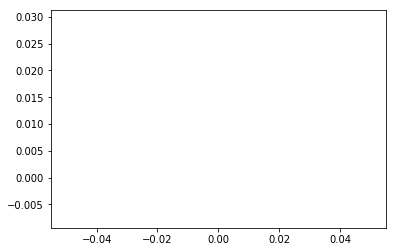

In [22]:
n_estimators = 20

r2_curve =[]

for min_samples_leaf in [10]:
    
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    r = test_params(this_regr_params)
    
    r2_curve.append(r)
    
plt.plot(r2_curve)

In [ ]:
n_estimators = 20

r2_curve =[]

for min_samples_leaf in [15]:
    
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    r = test_params(this_regr_params)
    
    r2_curve.append(r)
    
plt.plot(r2_curve)

n_estimators: 15,	 min_samples_leaf: 15
0:	temp train score: 0.311195, valid score: -0.006936
20:	temp train score: 0.310295, valid score: 0.025690
40:	temp train score: 0.316071, valid score: 0.027322
60:	temp train score: 0.306183, valid score: 0.028207
80:	temp train score: 0.311698, valid score: 0.029016
86:	temp train score: 0.311351, valid score: 0.029167
full data
0:	temp train score: 0.311108, valid score: 0.023814
20:	temp train score: 0.307653, valid score: 0.052350
40:	temp train score: 0.312460, valid score: 0.054025
60:	temp train score: 0.306909, valid score: 0.055156
80:	temp train score: 0.308138, valid score: 0.055658
86:	temp train score: 0.310802, valid score: 0.055724
saved


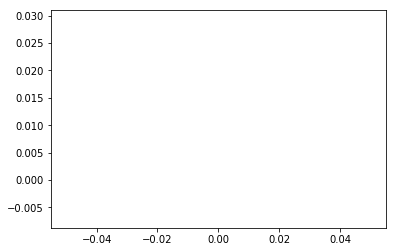

In [25]:
n_estimators = 15

r2_curve =[]

for min_samples_leaf in [15]:
    
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    r = test_params(this_regr_params)
    
    r2_curve.append(r)
    
plt.plot(r2_curve)

In [26]:
n_estimators = 15

r2_curve =[]

for min_samples_leaf in [10]:
    
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    r = test_params(this_regr_params)
    
    r2_curve.append(r)
    
plt.plot(r2_curve)

n_estimators: 15,	 min_samples_leaf: 10
0:	temp train score: 0.407775, valid score: -0.017550
20:	temp train score: 0.404765, valid score: 0.024551
40:	temp train score: 0.410299, valid score: 0.026605
60:	temp train score: 0.404845, valid score: 0.028160
80:	temp train score: 0.409492, valid score: 0.029072
86:	temp train score: 0.405659, valid score: 0.029256
full data
0:	temp train score: 0.406633, valid score: 0.024674
20:	temp train score: 0.405099, valid score: 0.058914
40:	temp train score: 0.409526, valid score: 0.061328


KeyboardInterrupt: 

n_estimators: 15,	 min_samples_leaf: 20
0:	temp train score: 0.252750, valid score: 0.000643
20:	temp train score: 0.252956, valid score: 0.025321
40:	temp train score: 0.253936, valid score: 0.027279
60:	temp train score: 0.249201, valid score: 0.028209
80:	temp train score: 0.253229, valid score: 0.028869
86:	temp train score: 0.251500, valid score: 0.028999
full data
0:	temp train score: 0.252143, valid score: 0.026080
20:	temp train score: 0.250995, valid score: 0.048008
40:	temp train score: 0.254619, valid score: 0.049496
60:	temp train score: 0.247168, valid score: 0.050398
80:	temp train score: 0.251868, valid score: 0.050932
86:	temp train score: 0.253868, valid score: 0.051005
saved


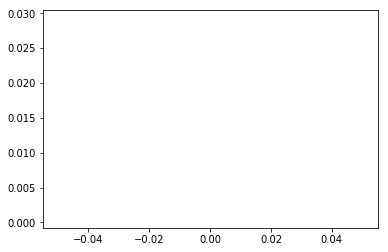

In [27]:
n_estimators = 15

r2_curve =[]

for min_samples_leaf in [20]:
    
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    r = test_params(this_regr_params)
    
    r2_curve.append(r)
    
plt.plot(r2_curve)

In [29]:
n_estimators = 15

min_samples_leaf = 10

this_regr_params = regr_parameters.copy()
this_regr_params['n_estimators'] = n_estimators
this_regr_params['min_samples_leaf'] = min_samples_leaf

print('n_estimators: %d,\t min_samples_leaf: %d'%(this_regr_params['n_estimators'],this_regr_params['min_samples_leaf']))

print('full data')
regr_full, _ , valid_score_full = RF87slice(this_regr_params,X_all_demean,y_all,X_test_demean, y_test)

out = {'model':regr_full,
      'model_params':this_regr_params,
      'features':ft_pick,
      'ft_range':df[ft_pick].max()-df[ft_pick].min(),
      'ft_mean':df[ft_pick].mean()}

path = 'RF0930_ft32_nt%d_mtl%d_fulldata'%\
                (this_regr_params['n_estimators'],this_regr_params['min_samples_leaf'])

model2pickle(out,  path)

n_estimators: 15,	 min_samples_leaf: 10
full data
0:	temp train score: 0.406633, valid score: 0.024674
20:	temp train score: 0.405099, valid score: 0.058914
40:	temp train score: 0.409526, valid score: 0.061328
60:	temp train score: 0.404693, valid score: 0.062854
80:	temp train score: 0.404266, valid score: 0.063519
86:	temp train score: 0.408802, valid score: 0.063526


In [31]:
min_samples_leaf = 15
for n_estimators in [17,18,19,20]:
    
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    r = test_params(this_regr_params)

n_estimators: 17,	 min_samples_leaf: 15
0:	temp train score: 0.312936, valid score: -0.003656
20:	temp train score: 0.312056, valid score: 0.025869
40:	temp train score: 0.317869, valid score: 0.027547
60:	temp train score: 0.309789, valid score: 0.028354
80:	temp train score: 0.313390, valid score: 0.029138
86:	temp train score: 0.313625, valid score: 0.029275
full data
0:	temp train score: 0.313363, valid score: 0.026551
20:	temp train score: 0.310426, valid score: 0.052378
40:	temp train score: 0.314180, valid score: 0.054026
60:	temp train score: 0.308966, valid score: 0.055156
80:	temp train score: 0.310739, valid score: 0.055673
86:	temp train score: 0.312336, valid score: 0.055739
saved
n_estimators: 18,	 min_samples_leaf: 15
0:	temp train score: 0.314132, valid score: -0.002419
20:	temp train score: 0.313247, valid score: 0.025890
40:	temp train score: 0.318693, valid score: 0.027538
60:	temp train score: 0.310428, valid score: 0.028415
80:	temp train score: 0.314109, valid sco

In [32]:
n_estimators = 15
for min_samples_leaf in [14,13,12,11]:
    
    this_regr_params = regr_parameters.copy()
    this_regr_params['n_estimators'] = n_estimators
    this_regr_params['min_samples_leaf'] = min_samples_leaf
    
    r = test_params(this_regr_params)

n_estimators: 15,	 min_samples_leaf: 14
0:	temp train score: 0.324863, valid score: -0.009216
20:	temp train score: 0.324976, valid score: 0.025155
40:	temp train score: 0.330380, valid score: 0.027025
60:	temp train score: 0.322730, valid score: 0.028123
80:	temp train score: 0.325635, valid score: 0.028991
86:	temp train score: 0.326363, valid score: 0.029160
full data
0:	temp train score: 0.326220, valid score: 0.023279
20:	temp train score: 0.323619, valid score: 0.053547
40:	temp train score: 0.327338, valid score: 0.055370
60:	temp train score: 0.321708, valid score: 0.056408
80:	temp train score: 0.323572, valid score: 0.056946
86:	temp train score: 0.326031, valid score: 0.057001
saved
n_estimators: 15,	 min_samples_leaf: 13
0:	temp train score: 0.343535, valid score: -0.012751
20:	temp train score: 0.340885, valid score: 0.025170
40:	temp train score: 0.346962, valid score: 0.027125
60:	temp train score: 0.339392, valid score: 0.028197
80:	temp train score: 0.343379, valid sco